In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

file_path = r"C:\Users\18014\Desktop\medical_clean.csv"

df = pd.read_csv(file_path)

df.set_index('Day', inplace=True)

print(df.head())

      Revenue
Day          
1    0.000000
2   -0.292356
3   -0.327772
4   -0.339987
5   -0.124888


In [2]:
#Checking for missing values and datatypes
print(df.isnull().sum())
print(df.dtypes)

Revenue    0
dtype: int64
Revenue    float64
dtype: object


In [3]:
df

,Revenue
Day,
1,0.000000
2,-0.292356
3,-0.327772
4,-0.339987
5,-0.124888
...,...
727,15.722056
728,15.865822
729,15.708988


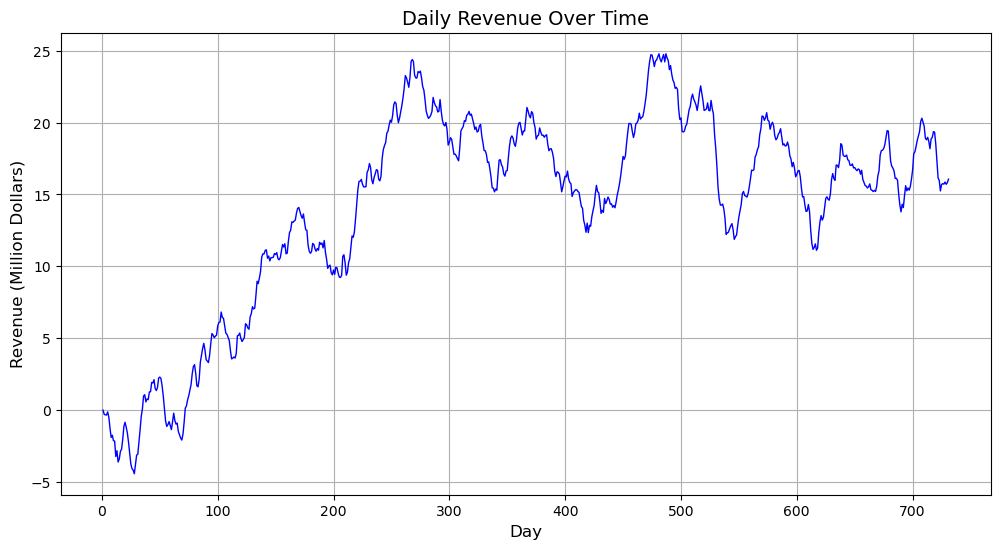

In [4]:
#Plotting the time series
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Revenue'], label='Revenue', color='blue', linewidth=1)
plt.title('Daily Revenue Over Time', fontsize=14)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Revenue (Million Dollars)', fontsize=12)
plt.grid(True)
plt.show()

In [5]:
#Augmented Dickey-Fuller (ADF) test
result = adfuller(df['Revenue'])

print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

ADF Statistic: -2.2183190476089436
p-value: 0.199664006150644
Critical Values: {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}


In [6]:
#Applying first-order differencing
df['Revenue_diff'] = df['Revenue'].diff().dropna()

result_diff = adfuller(df['Revenue_diff'].dropna())
print("ADF Statistic (Differenced):", result_diff[0])
print("p-value (Differenced):", result_diff[1])
print("Critical Values (Differenced):", result_diff[4])

ADF Statistic (Differenced): -17.374772303557066
p-value (Differenced): 5.113206978840171e-30
Critical Values (Differenced): {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}


In [7]:
#df.to_csv("C:/Users/18014/Desktop/data_cleaned.csv", index=False)

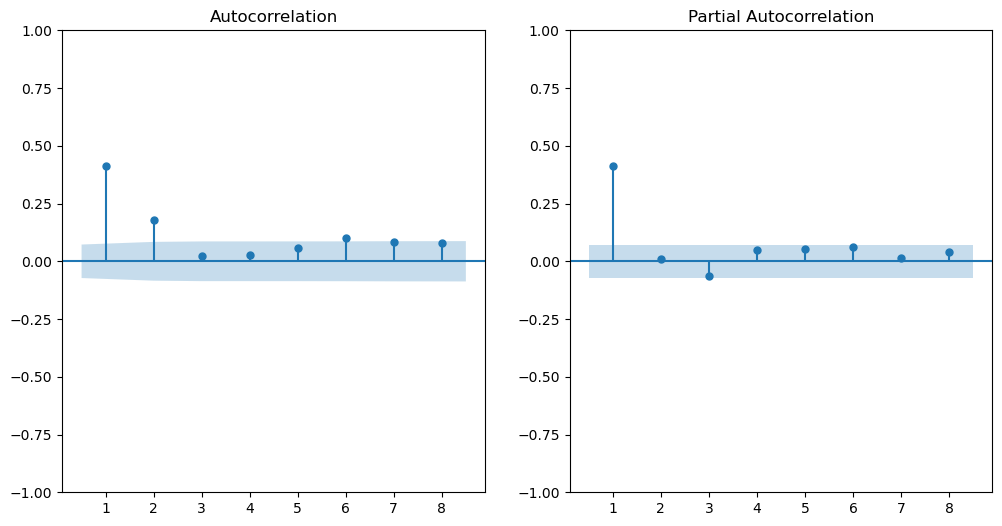

In [8]:
#Creating Autocorrelation plots
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(df['Revenue_diff'].dropna(), lags=8, zero=False, ax=plt.gca())
plt.subplot(122)
plot_pacf(df['Revenue_diff'].dropna(), lags=8, zero=False, ax=plt.gca())
plt.show()


In [9]:
#Droping NaN values from differencing
df_diff = df['Revenue_diff'].dropna()

#Split point (80% training, 20% test)
train_size = int(len(df_diff) * 0.8)
train, test = df_diff[:train_size], df_diff[train_size:]


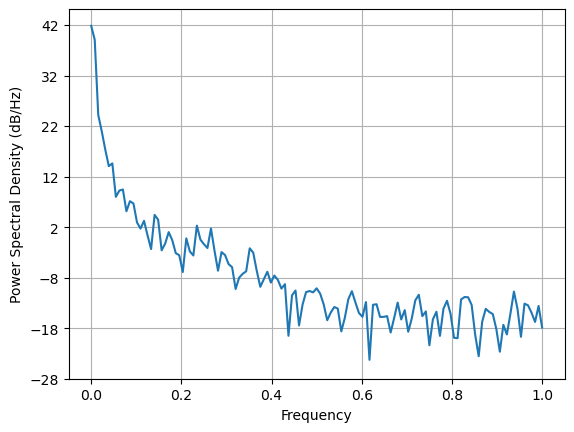

In [10]:
plt.psd(x=df.Revenue);

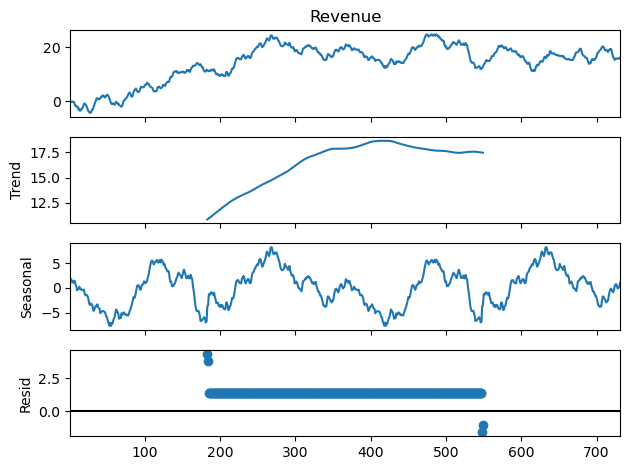

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

#Decomposed time series and plot
decomposition = seasonal_decompose(df['Revenue'], model='additive', period=365)
decomposition.plot()
plt.show()

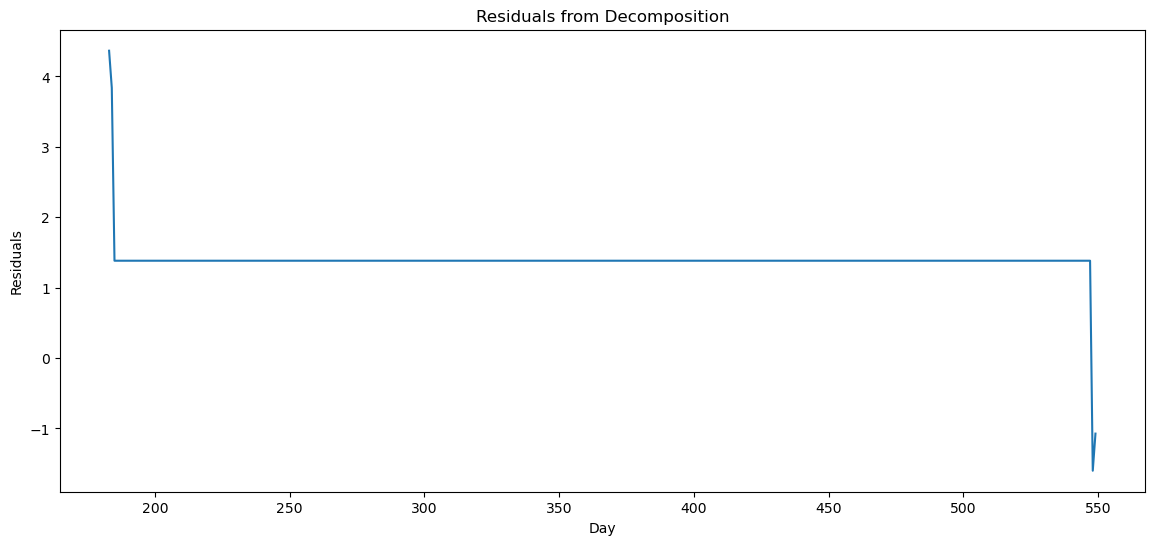

In [12]:
#Showing Residuals from decomposition
residuals = decomposition.resid

# Plot residuals
plt.figure(figsize = [14,6])
plt.plot(df.index, residuals, label='Residuals')
plt.title('Residuals from Decomposition')
plt.xlabel('Day')
plt.ylabel('Residuals')
plt.show()

In [13]:
#Using the train dataset for the ARIMA model with p=1, d=0, q=0
model = ARIMA(train, order=(1, 0, 0))
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:           Revenue_diff   No. Observations:                  584
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -350.349
Date:                Fri, 06 Dec 2024   AIC                            706.698
Time:                        01:47:51   BIC                            719.808
Sample:                             0   HQIC                           711.808
                                - 584                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0328      0.031      1.063      0.288      -0.028       0.093
ar.L1          0.4079      0.038     10.748      0.000       0.333       0.482
sigma2         0.1943      0.012     15.948      0.0

C:\Users\18014\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\18014\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\18014\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [14]:
#Forecasting the data using the start of the test set through the end
forecast = results.get_prediction(start=test.index[0], end=test.index[-1])
forecast_mean = forecast.predicted_mean
print(forecast.predicted_mean)

C:\Users\18014\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\18014\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


586    0.039159
587    0.035388
588    0.033850
589    0.033223
590    0.032967
         ...   
727    0.032791
728    0.032791
729    0.032791
730    0.032791
731    0.032791
Name: predicted_mean, Length: 146, dtype: float64


In [15]:
confidence_intervals = forecast.conf_int()
print(confidence_intervals)

     lower Revenue_diff  upper Revenue_diff
586           -0.904871            0.983190
587           -0.910461            0.981237
588           -0.912301            0.980001
589           -0.912978            0.979424
590           -0.913243            0.979177
..                  ...                 ...
727           -0.913421            0.979002
728           -0.913421            0.979002
729           -0.913421            0.979002
730           -0.913421            0.979002
731           -0.913421            0.979002

[146 rows x 2 columns]


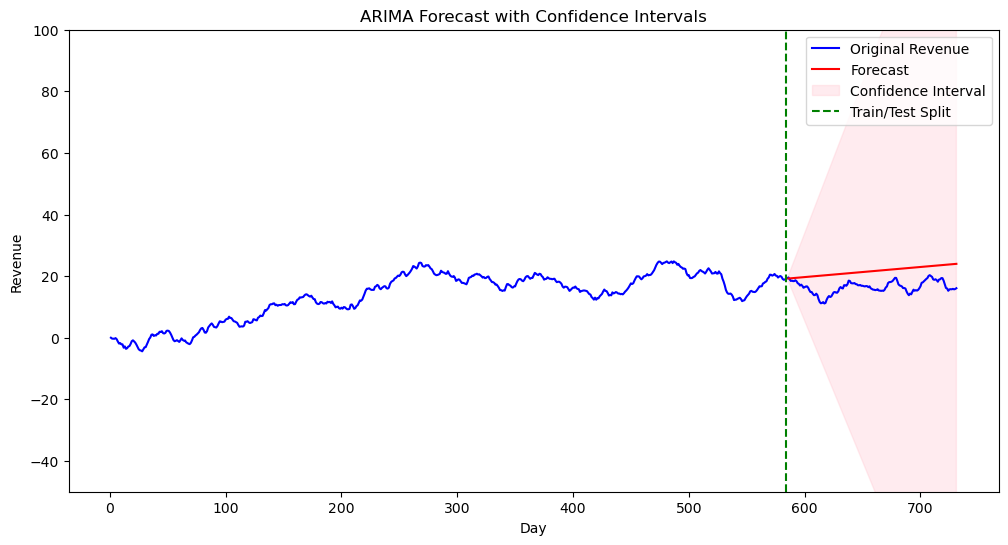

In [16]:
#Using cumulative sum to use the non-differenced predictions
forecast_mean_cumsum = forecast_mean.cumsum() + df['Revenue'].iloc[train_size - 1]
confidence_intervals_cumsum = confidence_intervals.cumsum() + df['Revenue'].iloc[train_size - 1]

#Plotting the ARIMA forecast with confidence cone
plt.figure(figsize=(12, 6))
plt.plot(df['Revenue'], label='Original Revenue', color='blue')
plt.plot(forecast_mean_cumsum, label='Forecast', color='red')
plt.fill_between(
    confidence_intervals_cumsum.index,
    confidence_intervals_cumsum.iloc[:, 0],
    confidence_intervals_cumsum.iloc[:, 1],
    color='pink', alpha=0.3, label='Confidence Interval'
)
plt.axvline(x=train_size, color='green', linestyle='--', label='Train/Test Split')
plt.legend()
plt.title('ARIMA Forecast with Confidence Intervals')
plt.xlabel('Day')
plt.ylabel('Revenue')
plt.ylim(-50, 100)
plt.show()


In [17]:
rmse = np.sqrt(mean_squared_error(test, forecast_mean))
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 0.4886573053785873
